# **SkinScan Model, by Cole Hopkins (CSCI490 Capstone)**
This is the model developed for my pox identification application to allow users to take pictures and get quick results from conditions on their skin. Using Tensorflow and Keras, as well as self-gathered images for the dataset. 

# Load Dataset and Libraries

Import Libraries

In [2]:
#tensorflow libraries
import tensorflow as tf #machine learning library
from tensorflow import keras #neural network library

#keras libraries
from keras.preprocessing.image import ImageDataGenerator #image augmentation tool
from keras import models, layers #import of models
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout #import of layers
from keras.metrics import categorical_crossentropy #loss function for model fitting

#sklearn libraries
from sklearn.model_selection import train_test_split #split images for training and validation
from sklearn.model_selection import GridSearchCV #optimize hyperparameters
from sklearn.metrics import confusion_matrix #determine confusion matrix from test results
from sklearn.metrics import ConfusionMatrixDisplay #display confusion matrix graph
from sklearn.metrics import classification_report #calculate f1-score, precision, recall, and support

#data and math libraries
import numpy as np #math library
from numpy.random import default_rng #true random variable
import pandas as pd #data analysis and manipulation library
import matplotlib.pyplot as plt #plotting data library
import seaborn as sns #plot graph for count of each label
from google.colab import files #for downloading model files after fitting model
from IPython.display import Image #displaying model png

import warnings #display warnings in code
import random #use true randomization
import tqdm #progess bar library for visualizing progress
import os #interact with operating system (folders and files)
import cv2 #opencv library

Import custom dataset from my apache server on my website

In [14]:
!wget -m -np -c -w 2 -R "index.html*" "https://capstone.colehopkins.me/dataset.zip" #download dataset
!unzip capstone.colehopkins.me/dataset.zip &> /dev/null #unzip dataset

--2022-12-16 01:04:06--  https://capstone.colehopkins.me/dataset.zip
Resolving capstone.colehopkins.me (capstone.colehopkins.me)... 104.21.60.148, 172.67.197.201, 2606:4700:3034::ac43:c5c9, ...
Connecting to capstone.colehopkins.me (capstone.colehopkins.me)|104.21.60.148|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘capstone.colehopkins.me/dataset.zip’ not modified on server. Omitting download.



display all images and there paths in loaded dataset

# Organize Dataset

**Label** each image for **classification** depending upon the sub directory it exists in. This will allow us to group all images with the specific **label** it belongs to, so that we can **classify** these images later

In [4]:
input_path = [] #directory path of each image
label = [] #class ID for each image

for class_name in os.listdir("dataset"): #for all class subdirectories in dataset directory
    for path in os.listdir("dataset/"+class_name): #for all images in each class subdirectory
        if class_name == 'chickenpox':
            label.append(0) #label chickenpox as 0
            input_path.append(os.path.join("dataset", class_name, path))
        if class_name == 'measels':
            label.append(1) #label measels as 1
            input_path.append(os.path.join("dataset", class_name, path))
        if class_name == 'shingles':
            label.append(2) #label shingles as 2
            input_path.append(os.path.join("dataset", class_name, path))

load sorted images into pandas dataframe, which will be useful for augmentation and organization of images in later steps. Print the first few images with the label assigned to them from the dataframe.

In [5]:
df = pd.DataFrame() #create a dataframe for holding info about each image
df['images'] = input_path #column to hold paths
df['label'] = label #column to hold label
df = df.sample(frac=1).reset_index(drop=True) #shuffle indexes for randomness
df.head() #display short snippet of structure of dataframe

,images,label
0,dataset/shingles/74-shingles.jpg,2
1,dataset/measels/179-measels.jpg,1
2,dataset/chickenpox/168-chickenpox.jpg,0
3,dataset/shingles/119-shingles.jpg,2
4,dataset/chickenpox/146-chickenpox.jpg,0


Visualize the data by using matplotlib to randomly display 5 images from each class.

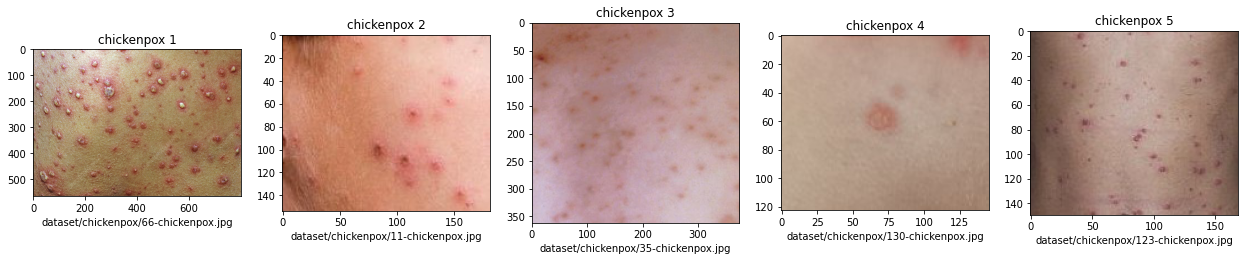

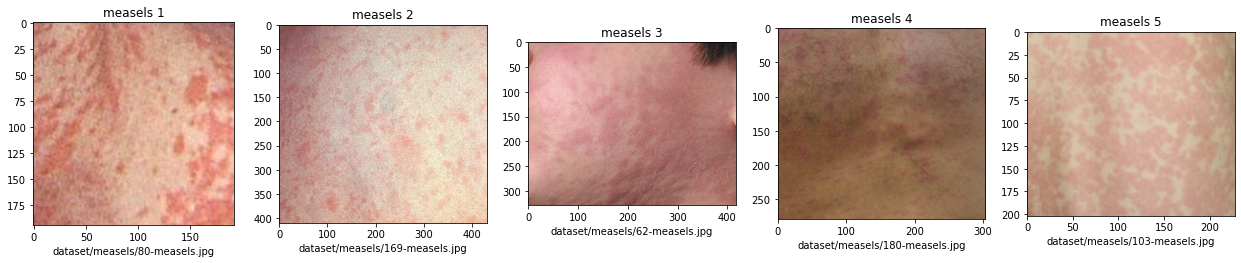

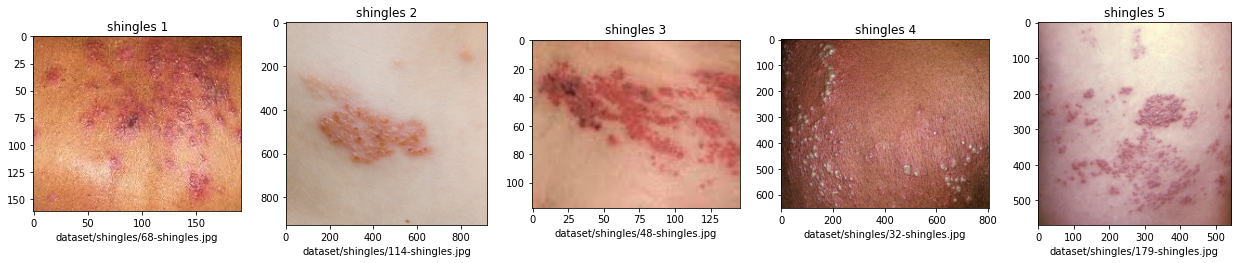

In [6]:
from keras_preprocessing.image import load_img

pox = ["chickenpox", "measels", "shingles"]

for x in range(len(pox)):
  plt.figure(figsize=(35, 35))
  temp = df[df['label'] == x]['images'] #gather all images of label "x"
  start = random.randint(0, len(temp)) #randomize images positions
  files = temp[start:start+5] #choose first five images in randomized images

  for index, file in enumerate(files): #for each image chosen
    plt.subplot(8,8, index+1) #
    img = load_img(file) #load image from file
    img = np.array(img) #load image into numpy array
    plt.imshow(img) #display numpy array image
    plt.title(pox[x]+" "+str(index+1)) #display title with index
    plt.xlabel(file) 
    plt.axis('on')

Display the count of images from each class.

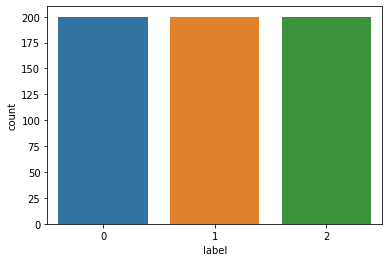

In [7]:
pox = ["chickenpox", "measels", "shingles"]
sns.countplot(x = df['label']) #



Randomly split the images into train, validation, and test images. This will allow for training and validating the model with specified images, and then test using the test images. Currently splitting the data with 75/15/10 (was 80/14/6)

In [8]:
df['label'] = df['label'].astype('str')
train, verify = train_test_split(df, test_size=0.25, stratify=df['label']) #split 75% of images towards training set
val, test = train_test_split(verify, test_size=0.40, stratify=verify['label']) #split 15$ of images to validation set, and 10% to test set

# Optimize Model

Use normalization on all 3 sets, as well as augmentation of training image set to allow for better training and predictions. 

Normalization can help training of our neural networks as the different features are on a similar scale, which helps to stabilize the gradient descent step, allowing us to use larger learning rates or help models converge faster for a given learning rate.

In [16]:
train_gen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range = 20,
    shear_range = 0.1,
    zoom_range = 0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip = True,
    fill_mode = 'nearest')

val_gen = ImageDataGenerator(rescale = 1./255)

test_gen = ImageDataGenerator(rescale = 1./255)

#load datasets with images from dataframe, for use in training and validating the model and testing afterwards
train_data = train_gen.flow_from_dataframe(train, x_col='images', y_col='label', target_size=(128,128), batch_size=6, shuffle=True, class_mode='categorical', seed = 42)
val_data = val_gen.flow_from_dataframe(val, x_col='images', y_col='label', target_size=(128,128), shuffle=True, class_mode='categorical', seed = 42)
test_data = test_gen.flow_from_dataframe(test, x_col='images', y_col='label', target_size=(128,128), shuffle=False, seed = 42)

Found 450 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
Found 60 validated image filenames belonging to 3 classes.


develop the model with the hidden layers type and output layer type

In [17]:
model = models.Sequential([
      layers.Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
      layers.MaxPool2D((2,2)),
      layers.Conv2D(32, (3,3), activation='relu'),
      layers.MaxPool2D((2,2)),
      layers.Conv2D(32, (3,3), activation='relu'),
      layers.MaxPool2D((2,2)),
      layers.Conv2D(16, (3,3), activation='relu'),
      layers.MaxPool2D((2,2)), 
      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dense(3, activation='softmax')
])

# best previously working model
    # layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    # layers.MaxPool2D(pool_size= (2,2), strides= 2),
    # layers.Conv2D(64, (3,3), activation='relu'),
    # layers.MaxPool2D(2,2),
    # layers.Flatten(),
    # layers.Dense(128, activation='relu'),
    # layers.Dense(4, activation='softmax'),

# best current model to prevent overfitting
    # layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    # layers.MaxPool2D(pool_size=(3,3)),
    # layers.Conv2D(32, (3,3), activation='relu'),
    # layers.MaxPool2D(pool_size=(3,3)),
    # layers.Dropout(0.15),
    # layers.Conv2D(64, (3,3), activation='relu'),
    # layers.MaxPool2D(pool_size=(3,3)),
    # layers.Dropout(0.15),
    # layers.Flatten(),
    # layers.Dense(256, activation='relu'),
    # layers.Dropout(0.15),
    # layers.Flatten(),
    # layers.Dense(4, activation='softmax'),

visualize the model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 24.3 MB/s 


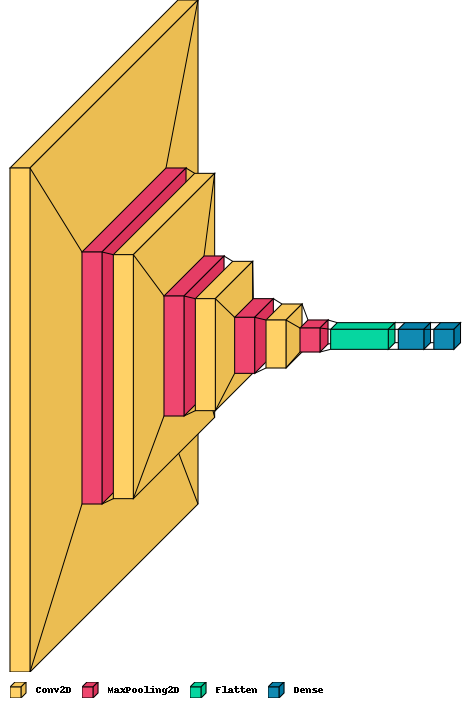

In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True) # selected font

# Develop Model

It is time to build and fit the model based off the parameters and other optimizations made so that the model can better predict results. First, build the model with specific loss and optimizer algorithms

In [18]:
opt = keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)      

Fit the model, running epochs of n size

In [19]:
overfit = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=4),
history = model.fit(train_data, epochs=50, shuffle=True, validation_data = val_data) #callbacks=overfit)

Epoch 1/50
75/75 [==============================] - 4s 49ms/step - loss: 1.1025 - accuracy: 0.2822 - val_loss: 1.0976 - val_accuracy: 0.3667
Epoch 2/50
75/75 [==============================] - 3s 46ms/step - loss: 1.0984 - accuracy: 0.3800 - val_loss: 1.0847 - val_accuracy: 0.3778
Epoch 3/50
75/75 [==============================] - 4s 47ms/step - loss: 1.0746 - accuracy: 0.4022 - val_loss: 1.0400 - val_accuracy: 0.4556
Epoch 4/50
75/75 [==============================] - 4s 47ms/step - loss: 1.0154 - accuracy: 0.4867 - val_loss: 0.9660 - val_accuracy: 0.4444
Epoch 5/50
75/75 [==============================] - 3s 45ms/step - loss: 0.9770 - accuracy: 0.5022 - val_loss: 1.0917 - val_accuracy: 0.4778
Epoch 6/50
75/75 [==============================] - 3s 46ms/step - loss: 0.9268 - accuracy: 0.5578 - val_loss: 0.9887 - val_accuracy: 0.5000
Epoch 7/50
75/75 [==============================] - 3s 46ms/step - loss: 0.9105 - accuracy: 0.5356 - val_loss: 1.0192 - val_accuracy: 0.5333
Epoch 8/50
75

Display the accuracy and loss of training and validation sets over epoch

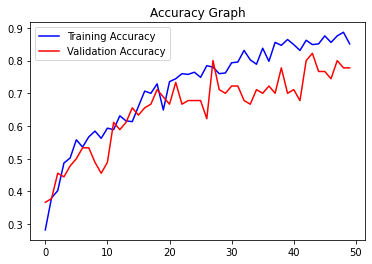

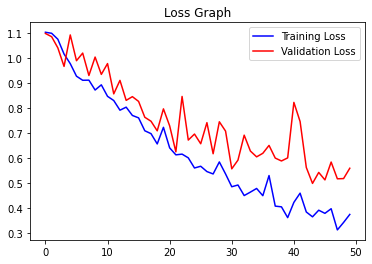

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Analyze Model

### **Evaluate**

After fitting the model, we need to check how accurate the results are with data not yet introduced to the model. Running the code below will evaluate the confidence of a test image being one of the four classes. A correct prediction improves our accuracy, while the confidence of our prediction versus the other classes determines our loss value. A high loss on an image tells us there is an error in the model, as it is not very confident on its predictions.

In [24]:
print("Evaluate")
result = model.evaluate(test_data)
dict(zip(model.metrics_names, result))

Evaluate
2/2 [==============================] - 0s 69ms/step - loss: 0.4513 - accuracy: 0.8333


{'loss': 0.45125898718833923, 'accuracy': 0.8333333134651184}

In [25]:
print("Predict")
result = model.predict(test_data)
dict(zip(model.metrics_names, result))

Predict
2/2 [==============================] - 0s 61ms/step


{'loss': array([0.44993913, 0.09924363, 0.45081726], dtype=float32),
 'accuracy': array([3.2072166e-01, 1.3007817e-04, 6.7914826e-01], dtype=float32)}

### **Prediction Accuracy**

Create a CSV that stores the test image class and the class that it predicted, so we can get a total accuracy value for our test set

In [26]:
#test_data.reset()
actual = str(test_data.labels)
prediction = model.predict(test_data)
predicted_class_indices=np.argmax(prediction,axis=1)
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pox = ["chickenpox", "measels", "shingles"]
poxpredict = [];
poxactual = [];
i = 0
correct = len(actual)

for item in predictions:
  
  if item == "0":
    if actual[i] != item:
      correct = correct - 1
    poxpredict.append("chickenpox")
  if item == "1":
    if actual[i] != item:
      correct = correct - 1
    poxpredict.append("measels")
  if item == "2":
    if actual[i] != item:
      correct = correct - 1
    poxpredict.append("shingles")
  i = i + 1

for item in actual:
  if item == "0":
    poxactual.append("chickenpox")
  if item == "1":
    poxactual.append("measels")
  if item == "2":
    poxactual.append("shingles")
# if item == "3":
#   poxactual.append("monkeypox")

prediction_accuracy = correct/len(actual)

results=pd.DataFrame({"Actual":poxactual, "Predictions":poxpredict})
results.to_csv("results.csv",index=False)
print(prediction_accuracy)

2/2 [==============================] - 0s 64ms/step
0.7166666666666667


### **Confusion Matrix**


The confusion matrix allows us to visualize the results of our predictions on the test set, those being TN, TP, FN, and FP

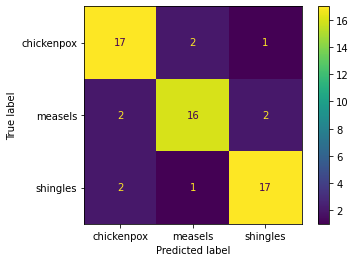

In [27]:
cm = confusion_matrix(poxactual, poxpredict)
cmdisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pox)
cmdisplay.plot()
plt.show()
Image(url='https://miro.medium.com/max/720/1*9TDo041I1jDfkoRI09Zeog.gif', width=370, height=280)

### **Detail Report**

---

**Precision** [ TP / (TP + TN) ]

Measure how accurate the model is from out of the correctly predicted images. A high precision tells us that our model results in alot of TP and TN values, while a low precision tells us that our class is inaccuratly predicting and giving negative results.

---

**Recall** [ *TP / (TP + FN)* ]

Measure to determine how well model is at not giving false negative results. This is an important for my model as health conditions should focus on minimizing these results, especially if the condition is life threatening

---

**F1-Score** [ *2 x ((Recall x Precision) / (Recall + Precision))* ]

Describes overall model performance by using precision and recall

---

**Support** [ *Class Test Size* ]

The number of test samples available for each class

---

**Accuracy** [ *(TP + TN) / (TP + TN + FP + FN)* ]

e

---

In [28]:
quality_report = classification_report(poxactual, poxpredict, zero_division=1)
print(quality_report)

              precision    recall  f1-score   support

  chickenpox       0.81      0.85      0.83        20
     measels       0.84      0.80      0.82        20
    shingles       0.85      0.85      0.85        20

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60



# Export Model to React Native

After model is fitted and training, validation, and test sets return strong accuracy and loss values, save the model to data file

In [29]:
model.save("PythonModel/pox.h5")

Convert the model data file into JavaScript readable file format (model.json and group1-shard.bin), for loading model locally into application

In [30]:
!pip3 install tensorflowjs &> /dev/null #for exporting python model to javascript model
!tensorflowjs_converter --input_format=keras PythonModel/pox.h5 JavaScriptModel
!type JavaScriptModel/*.bin > group1-shard.bin
!cat JavaScriptModel/*.bin > JavaScriptModel/group1-shard.bin #pipe all .bin into single .bin

2022-12-16 01:18:48.344886: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-12-16 01:18:48.346033: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-12-16 01:18:48.346065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/bin/bash: line 0: type: JavaScriptModel/group1-shard1of1

Download files to deploy into application

In [31]:
from google.colab import files
#files.download('/content/JavaScriptModel/group1-shard.bin')
#files.download('/content/JavaScriptModel/model.json')
!find /content/JavaScriptModel -path '*of*' -delete
!zip -r '/content/JavaScriptModel.zip' '/content/JavaScriptModel'
files.download('/content/JavaScriptModel.zip')

  adding: content/JavaScriptModel/ (stored 0%)
  adding: content/JavaScriptModel/model.json (deflated 84%)
  adding: content/JavaScriptModel/group1-shard.bin (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>